In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("waalbannyantudre/hate-speech-detection-curated-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/hate-speech-detection-curated-dataset


In [5]:
!pip install clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 3.1 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=616ef8495f404ab050372a65297d94ff2ac4c5de17f8ab2d36d18695df68c236
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.14.0
    Uninstalling emoji-2.14.0:
      Successfully uninstalled emoji-2.14.0


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cleantext import clean
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_nlp
from transformers import BertTokenizer
from keras.callbacks import EarlyStopping
sns.set()

In [7]:
df = pd.read_csv('/kaggle/input/hate-speech-detection-curated-dataset/HateSpeechDatasetBalanced.csv')
df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [8]:
df.shape

(726119, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726119 entries, 0 to 726118
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  726119 non-null  object
 1   Label    726119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ MB


In [10]:
df.isnull().sum()

Content    0
Label      0
dtype: int64

In [11]:
df.duplicated().sum()

25046

In [12]:
df.drop_duplicates(inplace = True)

In [13]:
df.shape

(701073, 2)

In [14]:
df['Label'].value_counts()

Label
1    359097
0    341976
Name: count, dtype: int64

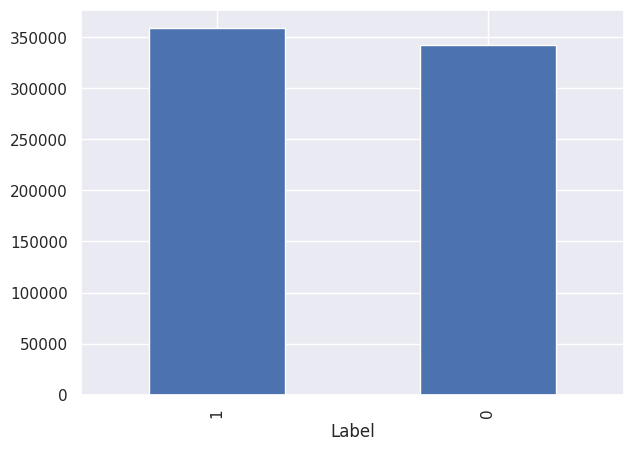

In [15]:
df['Label'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.show()

In [16]:
df0 = df[df['Label'] == 0].sample(15000)
df1 = df[df['Label'] == 1].sample(15000)

In [17]:
data = pd.concat([df0, df1])

In [18]:
data.shape

(30000, 2)

In [23]:
df['text'] = df['Content'].apply(lambda x : clean(x, no_emoji = True, no_line_breaks = True, no_punct = True,
                                                 lower = True, no_numbers = True))

In [24]:
df.head()

,Content,Label,text
0,denial of normal the con be asked to comment o...,1,denial of normal the con be asked to comment o...
1,just by being able to tweet this insufferable ...,1,just by being able to tweet this insufferable ...
2,that is retarded you too cute to be single tha...,1,that is retarded you too cute to be single tha...
3,thought of a real badass mongol style declarat...,1,thought of a real badass mongol style declarat...
4,afro american basho,1,afro american basho


In [25]:
df['word_count'] = df['text'].apply(lambda x : len(str(x.split())))

In [26]:
df.head()

,Content,Label,text,word_count
0,denial of normal the con be asked to comment o...,1,denial of normal the con be asked to comment o...,120
1,just by being able to tweet this insufferable ...,1,just by being able to tweet this insufferable ...,131
2,that is retarded you too cute to be single tha...,1,that is retarded you too cute to be single tha...,92
3,thought of a real badass mongol style declarat...,1,thought of a real badass mongol style declarat...,167
4,afro american basho,1,afro american basho,29


In [29]:
X = df['text']
y = df['Label']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, shuffle = True, 
                                                   stratify = y)

In [35]:
X_train = tf.ragged.constant(X_train.values)

In [37]:
X_test = tf.ragged.constant(X_test.values)

In [38]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train.values))

In [39]:
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test.values))

In [40]:
train_ds = train_ds.cache().shuffle(32).prefetch(tf.data.AUTOTUNE).batch(32)

In [41]:
test_ds = test_ds.cache().shuffle(32).prefetch(tf.data.AUTOTUNE).batch(32)

In [45]:
tokenizer = keras_nlp.models.BertTokenizer.from_preset('bert_small_en_uncased')

In [63]:
preprocessor = keras_nlp.models.BertPreprocessor(
    tokenizer, sequence_length = 80, truncate = 'round_robin'
)

In [64]:
model = keras_nlp.models.BertClassifier.from_preset(
    'bert_small_en_uncased', preprocessor = preprocessor, num_classes = 5
)

In [65]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [66]:
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = ['accuracy'],
    jit_compile = True
)

In [67]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)

In [68]:
history = model.fit(train_ds, validation_data = test_ds, epochs = 100, verbose = 1, callbacks = [early_stopping])

Epoch 1/100
17527/17527 ━━━━━━━━━━━━━━━━━━━━ 1528s 86ms/step - accuracy: 0.8145 - loss: 0.4138 - val_accuracy: 0.8651 - val_loss: 0.3015
Epoch 2/100
17527/17527 ━━━━━━━━━━━━━━━━━━━━ 1480s 84ms/step - accuracy: 0.8759 - loss: 0.2812 - val_accuracy: 0.8822 - val_loss: 0.2667
Epoch 3/100
17527/17527 ━━━━━━━━━━━━━━━━━━━━ 1474s 84ms/step - accuracy: 0.8972 - loss: 0.2370 - val_accuracy: 0.8896 - val_loss: 0.2520
Epoch 4/100
17527/17527 ━━━━━━━━━━━━━━━━━━━━ 1479s 84ms/step - accuracy: 0.9144 - loss: 0.2032 - val_accuracy: 0.8934 - val_loss: 0.2461
Epoch 5/100
17527/17527 ━━━━━━━━━━━━━━━━━━━━ 1474s 84ms/step - accuracy: 0.9268 - loss: 0.1745 - val_accuracy: 0.8950 - val_loss: 0.2500
Epoch 6/100
17527/17527 ━━━━━━━━━━━━━━━━━━━━ 1476s 84ms/step - accuracy: 0.9374 - loss: 0.1508 - val_accuracy: 0.8976 - val_loss: 0.2554
Epoch 7/100
17527/17527 ━━━━━━━━━━━━━━━━━━━━ 1479s 84ms/step - accuracy: 0.9463 - loss: 0.1305 - val_accuracy: 0.8984 - val_loss: 0.2666
